In [22]:
#Importing neccessary libararies
import re
import nltk
import torch
import string
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
# !pip install ekphrasis
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import nltk
import spacy
nlp = spacy.load("en_core_web_sm")
from nltk.stem import PorterStemmer
nltk.download('wordnet')
nltk.download('punkt')
import string
import torch
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [23]:
#Reading train and test data from the file
train_df = pd.read_csv("../NLP3/train.csv")
test_df = pd.read_csv("../NLP3/test.csv")
test_df.head()


,index,text,label
0,0,Detainees seen as minimal threat WASHINGTON --...,0
1,1,Japan's army works out plan to cope with North...,0
2,2,UN council arrives in Nairobi UN Security Coun...,0
3,3,APEC Ministers Urge New Effort on Trade Talks ...,0
4,4,At Least Five Dead in Russia Mine Blast (Reute...,0


In [24]:
#patter to remove HTML Tags 
pattern1 = r"&lt;.*?&gt;|#[0-9]*;|\([^)]*\)|\d+(st|nd|rd|th)|\d+"
punch_set = set(string.punctuation)
elements = {"'s","``","''","...","--"}
punch_set.update(elements)

def preprocess(text):
    text = text.lower()
    # replacing "\\" with space
    text = text.replace('\\', ' ')
    text = re.sub(pattern1,'',text) 
    # using spaCy for tokenization and lemmatization
    doc = nlp(text)
    updated_tokens = [token.lemma_ for token in doc if token.text not in punch_set and len(token.lemma_) > 1]
    text = " ".join(updated_tokens)
    return text


In [25]:
text = "Dallas. Mr. Morning. mr. mrs. News\\ to Lose Jobs  NEW YORK (Reuters) - Belo Corp. &lt;A HREF=""http://www.investor.reuters.com/FullQuote.aspx?ticker=BLC.N target=/stocks/quickinfo/fullquote""&gt;BLC.N&lt;/A&gt; said on Wednesday  it would cut more than 3 percent of its work force, mostly at  its Dallas Morning News, which is grappling with a recent  scandal into inflated circulation data provided to advertisers."
output = preprocess(text)
(output)

'dallas mr morning mr mrs news to lose job new york belo corp blc.n say on wednesday it would cut more than percent of its work force mostly at its dallas morning news which be grapple with recent scandal into inflated circulation datum provide to advertiser'

In [26]:
# applying preprocessing to train and test data frames 
train_df['preprocessed_text'] = train_df['text'].apply(preprocess)
test_df['preprocessed_text'] = test_df['text'].apply(preprocess)

In [27]:
# spliting train data into train and validation data.
X_Train, X_Val, Y_Train, Y_Val = train_test_split(train_df['preprocessed_text'],train_df['label'], train_size=0.9, random_state=42, shuffle=True)                                  
X_Train=X_Train.reset_index(drop=True)
X_Val=X_Val.reset_index(drop=True)
Y_Train=Y_Train.reset_index(drop=True)
Y_Val=Y_Val.reset_index(drop=True)
X_Test = test_df['preprocessed_text']
Y_Test = test_df['label']

In [28]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
max_seq_length = 64
batch_size = 32

In [29]:
#function to get word embeddings 
def tokenize_sentences(tokenizer, sentences, max_seq_length):
    input_ids = []
    for sent in sentences:
        encoded_dict = tokenizer.encode_plus(
            sent,
            add_special_tokens=True,
            max_length=max_seq_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=False,
            return_tensors='pt'
        )
        input_ids.append(encoded_dict['input_ids'])
        #attention_masks.append(encoded_dict['attention_mask'])
    return torch.cat(input_ids, dim=0)

In [30]:
train_input_ids = tokenize_sentences(tokenizer, X_Train, max_seq_length)
val_input_ids= tokenize_sentences(tokenizer, X_Val, max_seq_length)
test_input_ids = tokenize_sentences(tokenizer,X_Test, max_seq_length)

print("train_input_ids:", train_input_ids.shape)
print("val_input_ids:", val_input_ids.shape)
print("test_input_ids:", test_input_ids.shape)

train_input_ids: torch.Size([1800, 64])
val_input_ids: torch.Size([200, 64])
test_input_ids: torch.Size([500, 64])


In [31]:
train_labels = torch.tensor(Y_Train.values,dtype=torch.long)
val_labels = torch.tensor(Y_Val.values,dtype=torch.long)
test_labels = torch.tensor(Y_Test.values, dtype=torch.long) 
# train_labels.shape

In [32]:
#create train, val , test dataloader
dataset = TensorDataset(train_input_ids, train_labels)
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

dataset = TensorDataset(val_input_ids, val_labels)
val_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

dataset = TensorDataset(test_input_ids, test_labels)
test_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [33]:
for batch in train_dataloader:
    X, y = batch
    print("Shape of X:", X.shape)
    print("Shape of y:", y.shape)
    break

Shape of X: torch.Size([32, 64])
Shape of y: torch.Size([32])


In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [43]:
#using roberta-base model
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=4)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
num_epochs = 5
best_val_loss = float('inf')
best_model_state_dict = None
for epoch in range(num_epochs):
    model.train() # set model to train mode 
    train_losses = []
    train_preds = []
    train_labels_list = []
    val_labels_list =[]
    val_preds =[]
    val_losses = []
    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}', position=0, leave=True):
        input_ids, labels = batch
        input_ids = input_ids.to(device)
        labels = labels.to(device)
        outputs = model(input_ids=input_ids,  labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        train_preds.extend(preds.cpu().numpy())
        train_labels_list.extend(labels.cpu().numpy())

    train_accuracy = accuracy_score(train_labels_list, train_preds)
    avg_train_loss = np.mean(train_losses)

    # Validation
    model.eval() # set model to evaluation mode
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids, labels = batch
            input_ids = input_ids.to(device)
            labels = labels.to(device)
            outputs = model(input_ids=input_ids, labels=labels)
            val_losses.append(outputs.loss.item())
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels_list.extend(labels.cpu().numpy())
    avg_val_loss = np.mean(val_losses)
    val_accuracy = accuracy_score(val_labels_list, val_preds)
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss}, val Loss: {avg_val_loss}, Val Accuracy: {val_accuracy}')
    # Save the model with the best validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
#         best_model_state_dict = model.state_dict()
        torch.save(model.state_dict(), 'best_model_loss.pth') #saving best model 
    model.train()

Epoch 1/5: 100%|██████████| 57/57 [00:10<00:00,  5.27it/s]


Epoch 1/5, Train Loss: 0.8110159886510748, val Loss: 0.4627612829208374, Val Accuracy: 0.905


Epoch 2/5: 100%|██████████| 57/57 [00:10<00:00,  5.27it/s]


Epoch 2/5, Train Loss: 0.3622697854512616, val Loss: 0.2887673516358648, Val Accuracy: 0.905


Epoch 3/5: 100%|██████████| 57/57 [00:10<00:00,  5.28it/s]


Epoch 3/5, Train Loss: 0.2833093536788957, val Loss: 0.40693239654813496, Val Accuracy: 0.89


Epoch 4/5: 100%|██████████| 57/57 [00:10<00:00,  5.28it/s]


Epoch 4/5, Train Loss: 0.20895491916228803, val Loss: 0.3378362687570708, Val Accuracy: 0.905


Epoch 5/5: 100%|██████████| 57/57 [00:10<00:00,  5.28it/s]


Epoch 5/5, Train Loss: 0.16912508644817167, val Loss: 0.3292806340115411, Val Accuracy: 0.885


In [37]:
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=4)
# Load the saved state dict
model.load_state_dict(torch.load('best_model_loss.pth')) #load best bert model 
model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [38]:
#functon to get accuracy of the model
def getAccuracy(dataloader,model):
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids,labels = batch
            input_ids = input_ids.to(device)
            # attention_mask = attention_mask.to(device)
            labels = labels.to(device)
            outputs = model(input_ids=input_ids)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            all_predictions.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_predictions)
    return accuracy, all_predictions, all_labels
train_accuracy,train_all_predictions, train_all_labels = getAccuracy(train_dataloader,model)
print(f'Training Accuracy BERT: {train_accuracy:.4f}')
val_accuracy,val_all_predictions, val_all_labels = getAccuracy(val_dataloader,model)
print(f'validation Accuracy BERT: {val_accuracy:.4f}')
test_accuracy,test_all_predictions, test_all_labels = getAccuracy(test_dataloader,model)
print(f'Testing Accuracy BERT: {test_accuracy:.4f}')

Training Accuracy BERT: 0.9633
validation Accuracy BERT: 0.9150
Testing Accuracy BERT: 0.8760


Test Accuracy BERT: 0.8760
Macro-F1 Score BERT: 0.8754


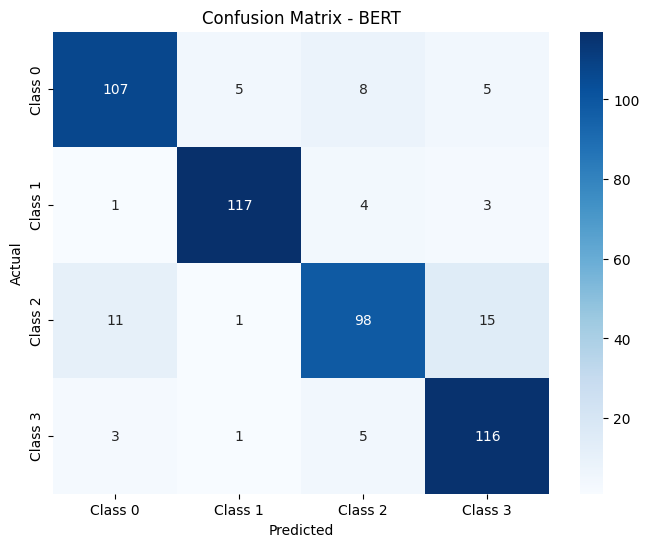

In [39]:
# printing confusion matrix 
conf_matrix = confusion_matrix(test_all_labels, test_all_predictions)
print(f'Test Accuracy BERT: {test_accuracy:.4f}')

# Calculate macro-F1 score
macro_f1 = f1_score(test_all_labels, test_all_predictions, average='macro')
print(f'Macro-F1 Score BERT: {macro_f1:.4f}')

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - BERT')
plt.show()

In [40]:
#printing classification report
from sklearn.metrics import confusion_matrix, classification_report
cr = classification_report(test_all_labels, test_all_predictions)
print(cr)

              precision    recall  f1-score   support

           0       0.88      0.86      0.87       125
           1       0.94      0.94      0.94       125
           2       0.85      0.78      0.82       125
           3       0.83      0.93      0.88       125

    accuracy                           0.88       500
   macro avg       0.88      0.88      0.88       500
weighted avg       0.88      0.88      0.88       500



In [41]:
#saving prediction in the bert_test.csv file 
df = pd.read_csv("../NLP3/test.csv")
test_df_copy =df
test_df_copy.insert(loc=3, column='preds', value=test_all_predictions)
#saving prediction into w2v_test.csv file 
test_df_copy.to_csv("bert_test.csv")